In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cpu


In [ ]:
mnist_transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(), 
                              transforms.Normalize((0.5,), (0.5,)) 
                              ])

train_dataset = datasets.MNIST(root='D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data', 
                                  train=True, 
                                  download=True, 
                                  transform=mnist_transform)

validation_dataset = datasets.MNIST(root='D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data', 
                                  train=False, 
                                  download=True, 
                                  transform=mnist_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) # shuffle training data before each epoch to avoid local min
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data/MNIST/raw



(택 1) model 1: for NN, model 2: for CNN

In [ ]:
#for NN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc1 = nn.Linear(28*28, 500)      
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)       
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)  
        return x

In [ ]:
#for CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, 
                              kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 30, 
                              kernel_size = 3, stride = 1, padding = 0)       
        self.fc1 = nn.Linear(5*5*30, 500)      
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        x = x.view(-1, 5*5*30)
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)
        return x

In [ ]:
torch.manual_seed(1)
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=750, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params+=param
  print(table)
  print('Total Trainable Params: {}'.format(total_params))
  return total_params
    
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    750     |
|  conv1.bias  |     30     |
| conv2.weight |    8100    |
|  conv2.bias  |     30     |
|  fc1.weight  |   375000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 389420


389420

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

t0 = int(round(time.time()))

for eno in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0

  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_loader: 
    inputs = inputs.to(device)  # use GPU
    labels = labels.to(device)  # use GPU

    # inputs = inputs.view(inputs.shape[0], -1)  #for NN
    outputs = model(inputs)
    loss = criterion(outputs, labels) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, pred_idx = torch.max(outputs, 1) 
    running_loss += loss.item() 
    running_corrects += torch.sum(pred_idx == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)  # use GPU
        val_labels = val_labels.to(device)  # use GPU

        # val_inputs = val_inputs.view(val_inputs.shape[0], -1) # for NN
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corrects.float()/ len(train_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('--------epoch :', (eno+1), '-----------------------')
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)    
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

print('Time elapsed {}seconds'.format(int(round(time.time())) - t0))

--------epoch : 1 -----------------------
training loss: 0.1594, acc 95.2350 
validation loss: 0.0470, validation acc 98.3600 
--------epoch : 2 -----------------------
training loss: 0.0452, acc 98.6150 
validation loss: 0.0335, validation acc 98.8600 
--------epoch : 3 -----------------------
training loss: 0.0304, acc 99.0133 
validation loss: 0.0485, validation acc 98.4900 
--------epoch : 4 -----------------------
training loss: 0.0222, acc 99.3000 
validation loss: 0.0260, validation acc 99.1400 
--------epoch : 5 -----------------------
training loss: 0.0180, acc 99.4317 
validation loss: 0.0276, validation acc 99.0800 
--------epoch : 6 -----------------------
training loss: 0.0131, acc 99.5350 
validation loss: 0.0302, validation acc 99.0100 
--------epoch : 7 -----------------------
training loss: 0.0128, acc 99.5783 
validation loss: 0.0268, validation acc 99.2100 
--------epoch : 8 -----------------------
training loss: 0.0113, acc 99.6217 
validation loss: 0.0297, validati

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
def fConvertImg(tensor):
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1, 2, 0)       
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
  image = image.clip(0, 1) 
  return image

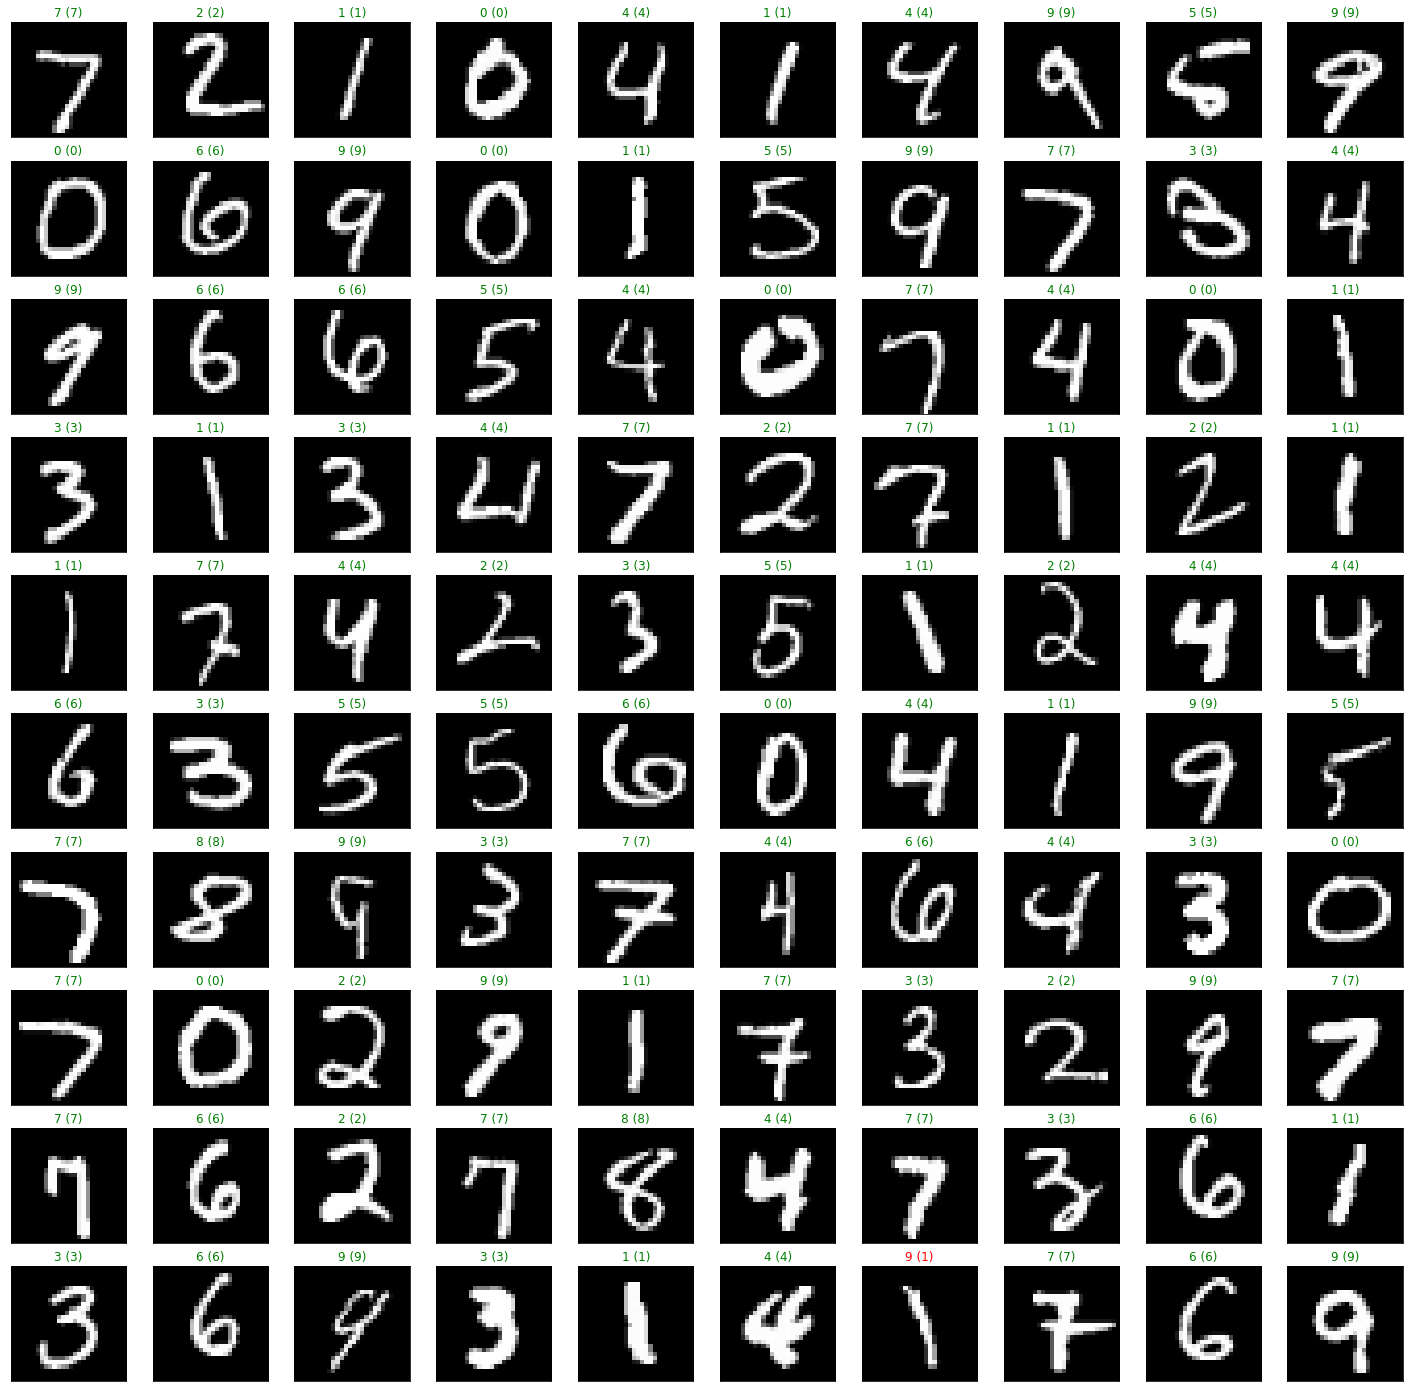

In [ ]:
dataiter = iter(validation_loader) # iter() returns an iterator for the given iterable object.
images, labels = dataiter.next()

images = images.to(device)  # use GPU
labels = labels.to(device)  # use GPU

output = model(images.view(images.shape[0], -1))    # for NN model
# output = model(images)                            # for CNN model
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 25))

for idx in np.arange(len(dataiter)):
  ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(fConvertImg(images[idx]))  
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))